## Prioritize the Inspections

We have to inspect a representative set of warning and report those that are highly likely to reply. Each warning belong to a different repository. We have to prioritize the inspections in order to maximize the number of replies.

Some characteristics that we might use to prioritize the inspections are:
1. The number of stars of the repository.
1. The number of issues of the repository.
1. The number of commits of the repository.
1. The number of contributors of the repository.
1. Days since last commit.

We can use the following formula to calculate the priority of a repository.
It computes the percentile for each attribute and then sums them, note that the percentile for says since last commit follows an inverse logic, the lower the value the higher the percentile.
$$
Priority = Percentile_{stars} + Percentile_{issues} + Percentile_{commits} + Percentile_{contributors} + (1 - Percentile_{days})

In [1]:
import project_path
from rdlib import *  # this imports the base libraries

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [51]:
# DATA
# SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2023-09-18_17-17-54"
SARIF_FOLDER = "../data/analysis_results/exp_v08/codeql_2024-03-01_08-43-53"
# TARGET NAME
# TARGET_FILENAME = "data_sample_fixed_10.csv"
TARGET_FILENAME = "data_sample_representative_10.csv"
# RAW FILES PATH
# RAW_FILES_PATH = "data_sample_fixed_10"
RAW_FILES_PATH = "data_sample_representative_10"
# ANNOTATIONS
# ANNOTATIONS_FILENAME = "Annotation_03_data_sample_fixed_10.csv"
ANNOTATIONS_FILENAME = "Annotation_04_data_sample_representative_10.csv"

NAME_MAPPING = {
    'ql-double-measurement': 'DoubleMeas',
    'ql-operation-after-measurement': 'OpAfterMeas',
    'ql-measure-all-abuse': 'MeasAllAbuse',
    'ql-constant-classic-bit': 'ConstClasBit',
    'ql-conditional-without-measurement': 'CondWoMeas',
    'ql-unmeasurable-qubits': 'InsuffClasReg',
    'ql-oversized-circuit': 'OversizedCircuit',
    'ql-op-after-optimization': 'OpAfterTransp',
    'ql-ghost-composition': 'GhostCompose',
    'ql-deprecated-identity': 'OldIdenGate',
}

GITHUB_TOKEN_PATH = "../secrets/github_access_token.txt"
GITHUB_TOKEN = open(GITHUB_TOKEN_PATH).read().strip()

In [53]:
df = pd.read_csv(os.path.join(SARIF_FOLDER, TARGET_FILENAME))
# keep only rule_id in the mapping NAME_MAPPING
df = df[df['rule_id'].isin(NAME_MAPPING.keys())]

df_annotations = pd.read_csv(os.path.join(SARIF_FOLDER, ANNOTATIONS_FILENAME))

# Add the 'label' column
df_annotations['label'] = df_annotations["Last Round"]

# Merge on rule_id, message, file, line, col
df = df.merge(df_annotations, on=["rule_id", "message", "file", "line", "col"])

# count different value counts of labels
value_counts = df['label'].value_counts()
print(value_counts)
print("Total:", value_counts.sum())
df.head()



label
TP    221
FP     77
NW     47
Name: count, dtype: int64
Total: 345


rule_id                               message  \
0  ql-deprecated-identity  The deprecated iden() API is called.   
1  ql-deprecated-identity  The deprecated iden() API is called.   
2  ql-deprecated-identity  The deprecated iden() API is called.   
3  ql-deprecated-identity  The deprecated iden() API is called.   
4  ql-deprecated-identity  The deprecated iden() API is called.   

                                             file  line  col index  \
0                      test_noise_model_bb93ba.py   549  9.0   NaN   
1                   4_qbits_decoherence_9bbc1f.py   397  9.0   NaN   
2  022_03b_bernstein_vazirani_algorithm_f13ae3.py    39  9.0   NaN   
3                          deutch_jozsa_ba9beb.py   133  3.0   NaN   
4                         bit_flip_code_f40402.py    48  NaN   NaN   

  Annotator_1 Annotator_2 Resolution Last Round Resolution comment same  \
0          FP         NaN        NaN         FP                NaN  NaN   
1          TP         NaN        NaN         TP                NaN  NaN   
2          NW         NaN        NaN         NW                NaN  NaN   
3          FP         NaN        NaN         FP                NaN  NaN   
4          TP         NaN        NaN         TP                NaN  NaN   

  issue_local  reported_as issue_url status reason  comment_2  reason.1 label  
0         NaN  no_inactive       NaN    NaN   RDI5        NaN       NaN    FP  
1         NaN  no_inactive       NaN    NaN   RDI1        NaN       NaN    TP  
2         NaN  no_inactive       NaN    NaN   RDI2        NaN       NaN    NW  
3         NaN  no_inactive       NaN    NaN   RDI3        NaN       NaN    FP  
4         NaN  no_inactive       NaN    NaN   RDI1        NaN       NaN    TP

In [54]:
def get_url_of_local_file(folder_with_raw_files, file_name):
    """Return the url of the local file.

    Note that the url is stored in the first lines of the local file, thus we
    need to read the file and extract the url.
    """
    with open(os.path.join(folder_with_raw_files, file_name), "r") as f:
        url = f.readline().strip()
    # remove the starting hashtag for comment
    url = url[1:].strip()
    return url

df_with_url = df.copy()
df_with_url["url"] = df_with_url["file"].apply(
    lambda x: get_url_of_local_file(
        os.path.join(SARIF_FOLDER, RAW_FILES_PATH), x))
# extract repo owner
df_with_url["repo_owner"] = df_with_url["url"].apply(lambda x: x.split("/")[3])
# extract repo name
df_with_url["repo_name"] = df_with_url["url"].apply(lambda x: x.split("/")[4])
df_with_url.head()

rule_id                               message  \
0  ql-deprecated-identity  The deprecated iden() API is called.   
1  ql-deprecated-identity  The deprecated iden() API is called.   
2  ql-deprecated-identity  The deprecated iden() API is called.   
3  ql-deprecated-identity  The deprecated iden() API is called.   
4  ql-deprecated-identity  The deprecated iden() API is called.   

                                             file  line  col index  \
0                      test_noise_model_bb93ba.py   549  9.0   NaN   
1                   4_qbits_decoherence_9bbc1f.py   397  9.0   NaN   
2  022_03b_bernstein_vazirani_algorithm_f13ae3.py    39  9.0   NaN   
3                          deutch_jozsa_ba9beb.py   133  3.0   NaN   
4                         bit_flip_code_f40402.py    48  NaN   NaN   

  Annotator_1 Annotator_2 Resolution Last Round  ...  reported_as issue_url  \
0          FP         NaN        NaN         FP  ...  no_inactive       NaN   
1          TP         NaN        NaN         TP  ...  no_inactive       NaN   
2          NW         NaN        NaN         NW  ...  no_inactive       NaN   
3          FP         NaN        NaN         FP  ...  no_inactive       NaN   
4          TP         NaN        NaN         TP  ...  no_inactive       NaN   

  status reason comment_2 reason.1 label  \
0    NaN   RDI5       NaN      NaN    FP   
1    NaN   RDI1       NaN      NaN    TP   
2    NaN   RDI2       NaN      NaN    NW   
3    NaN   RDI3       NaN      NaN    FP   
4    NaN   RDI1       NaN      NaN    TP   

                                                 url     repo_owner  \
0  https://github.com/frevson/Qiskit-Aer/blob/dac...        frevson   
1  https://github.com/NTrevisani/DataScienceMaste...     NTrevisani   
2  https://github.com/camitava0321/quantumComputi...   camitava0321   
3  https://github.com/DEBARGHYA4469/quantum-compi...  DEBARGHYA4469   
4  https://github.com/anandukmadhu/QEC-code/blob/...   anandukmadhu   

           repo_name  
0         Qiskit-Aer  
1  DataScienceMaster  
2   quantumComputing  
3   quantum-compiler  
4           QEC-code  

[5 rows x 23 columns]

In [55]:
import requests
from datetime import datetime, timezone
from functools import lru_cache
from time import sleep

N_GITHUB_API_CALLS = 0

@lru_cache(maxsize=None)
def get_repo_info(owner, repo):
    global N_GITHUB_API_CALLS
    print(f"Number of GitHub API calls: {N_GITHUB_API_CALLS}")
    print(f"Getting info for {owner}/{repo}")
    base_url = f"https://api.github.com/repos/{owner}/{repo}"

    headers = {
        "Authorization": f"Bearer {GITHUB_TOKEN}",
    }

    # Get general repo info
    response = requests.get(base_url, headers=headers)
    data = response.json()
    # if not found return all None
    if data.get("message") == "Not Found":
        return {
            "name": None,
            "stars": None,
            "issues": None,
            "forks": None,
            "contributors": None,
            "commits": None,
            "latest_commit_date": None,
            "days_since_latest_commit": None,
        }

    # Get contributors info
    contributors_response = requests.get(f"{base_url}/contributors", headers=headers)
    contributors_data = contributors_response.json()
    contributors_count = len(contributors_data)

    # Get commits info
    commits_response = requests.get(f"{base_url}/commits", headers=headers)
    commits_data = commits_response.json()
    commits_count = len(commits_data)
    # set default value for latest_commit_date and days_since_latest_commit
    latest_commit_date = None
    days_since_latest_commit = None
    # if there is at least one commit, get the date of the latest commit
    if commits_count > 0:
        try:
            # print(commits_data)
            latest_commit_date = commits_data[0]['commit']['author']['date']

            # Compute the number of days since the latest commit
            latest_commit_date = datetime.strptime(latest_commit_date, "%Y-%m-%dT%H:%M:%SZ")
            # Convert offset-naive datetime to offset-aware datetime
            latest_commit_date = latest_commit_date.replace(tzinfo=timezone.utc)
            now = datetime.now(timezone.utc)
            days_since_latest_commit = (now - latest_commit_date).days
        except:
            print(f"Error while getting latest commit date for {owner}/{repo}")

    N_GITHUB_API_CALLS += 3
    sleep(3)  # sleep for 3 seconds to avoid rate limit

    return {
        "name": data["name"],
        "stars": data["stargazers_count"],
        "issues": data["open_issues_count"],
        "forks": data["forks_count"],
        "contributors": contributors_count,
        "commits": commits_count,
        "latest_commit_date": latest_commit_date,
        "days_since_latest_commit": days_since_latest_commit,
    }

# Usage
info = get_repo_info("steurendoit", "QuantumTests")
print(info)

print(N_GITHUB_API_CALLS)

Number of GitHub API calls: 0
Getting info for steurendoit/QuantumTests
{'name': None, 'stars': None, 'issues': None, 'forks': None, 'contributors': None, 'commits': None, 'latest_commit_date': None, 'days_since_latest_commit': None}
0


In [56]:
# keep only top 10 rows
# df_with_url = df_with_url.head(10)
df_with_url.shape

(345, 23)

In [57]:
# check the the prioritization csv exists, if yes load it

prioritization_csv_path = os.path.join(SARIF_FOLDER, TARGET_FILENAME.replace(".csv", "_for_prioritization.csv"))

if os.path.exists(prioritization_csv_path):
    print(f"Loading from disk: \n{prioritization_csv_path}")
    df_with_url = pd.read_csv(prioritization_csv_path)
else:
    print(f"Computing {prioritization_csv_path} (from GitHub API)")
    print(N_GITHUB_API_CALLS)
    # Get repo info for each row
    df_with_url[['name', 'stars', 'issues', 'forks', 'contributors', 'commits', 'latest_commit_date', 'days_since_latest_commit']] = df_with_url.apply(lambda row: get_repo_info(row['repo_owner'], row['repo_name']), axis=1, result_type='expand')
    print(N_GITHUB_API_CALLS)
    display(df_with_url.head())

    print(N_GITHUB_API_CALLS)

    # store the dataframe in the same folder with the _for_prioritization suffix
    df_with_url.to_csv(
        os.path.join(SARIF_FOLDER, TARGET_FILENAME.replace(".csv", "_for_prioritization.csv")), index=False)


Loading from disk: 
../data/analysis_results/exp_v08/codeql_2024-03-01_08-43-53/data_sample_representative_10_for_prioritization.csv


## Explorative Data Analysis

In [58]:
df_with_url["reported_as"].value_counts()

reported_as
no_teaching_code             50
no_inactive                  44
no_because_test              38
new_report                   34
no_interactive_use           17
comment_in_related_report    13
no_single_file_repo          11
no_repo_archived             10
no_sketch_code                8
TO_DISCUSS_BETTER             5
TO_DISCUSS                    4
TO_REPORT                     2
no_artificial                 1
Name: count, dtype: int64

In [61]:
df_to_explore = df_with_url.copy()

mapping_reported_as = {
    "no_inactive": "Unreported Because Unmantained",
    "no_single_file_repo": "Unreported Because Incomplete Personal Program Sketches",
    "no_because_test": "Unreported Because Testing Other Features",
    "no_teaching_code": "Unreported Because Teaching Code",
    "comment_in_related_report": "Reported",
    "new_report": "Reported",
    "no_sketch_code": "Unreported Because Incomplete Personal Program Sketches",
    "TO_REPORT": "new detector To Report",
    "no_repo_archived": "Unreported Because Archived",
    "no_interactive_use": "Unreported Because Intermediate Visualization",
}
# map reported_as column to a more readable format
# use the map function
df_to_explore["reported_as"] = \
    df_to_explore["reported_as"].map(
        mapping_reported_as)

df_to_explore

rule_id  \
0    ql-deprecated-identity   
1    ql-deprecated-identity   
2    ql-deprecated-identity   
3    ql-deprecated-identity   
4    ql-deprecated-identity   
..                      ...   
356  ql-unmeasurable-qubits   
357  ql-unmeasurable-qubits   
358  ql-unmeasurable-qubits   
359  ql-unmeasurable-qubits   
360  ql-unmeasurable-qubits   

                                               message  \
0                 The deprecated iden() API is called.   
1                 The deprecated iden() API is called.   
2                 The deprecated iden() API is called.   
3                 The deprecated iden() API is called.   
4                 The deprecated iden() API is called.   
..                                                 ...   
356  Circuit 'qc' has more qubits (5) than classica...   
357  Circuit 'opt_qc3' has more qubits (10) than cl...   
358  Circuit 'circuit' has more qubits (2) than cla...   
359  Circuit 'qc' has more qubits (1) than classica...   
360  Circuit 'qc' has more qubits (13) than classic...   

                                               file  line   col  \
0                        test_noise_model_bb93ba.py   549   9.0   
1                     4_qbits_decoherence_9bbc1f.py   397   9.0   
2    022_03b_bernstein_vazirani_algorithm_f13ae3.py    39   9.0   
3                            deutch_jozsa_ba9beb.py   133   3.0   
4                           bit_flip_code_f40402.py    48   NaN   
..                                              ...   ...   ...   
356                                   qpe_29beb1.py    44  10.0   
357                             benchmark_72ca3d.py  1531  11.0   
358                                  main_ac3fb4.py    93  11.0   
359                               base_nb_a6e7a0.py   717   6.0   
360                                  qram_f283bf.py  4078  10.0   

                                                 index Annotator_1  \
0                                                  NaN          FP   
1                                                  NaN          TP   
2                                                  NaN          NW   
3                                                  NaN          FP   
4                                                  NaN          TP   
..                                                 ...         ...   
356  Circuit 'qc' has more qubits (5) than classica...          NW   
357  Circuit 'opt_qc3' has more qubits (10) than cl...          NW   
358  Circuit 'circuit' has more qubits (2) than cla...          FP   
359  Circuit 'qc' has more qubits (1) than classica...          FP   
360  Circuit 'qc' has more qubits (13) than classic...          FP   

    Annotator_2 Resolution Last Round  ...      repo_owner          repo_name  \
0           NaN        NaN         FP  ...         frevson         Qiskit-Aer   
1           NaN        NaN         TP  ...      NTrevisani  DataScienceMaster   
2           NaN        NaN         NW  ...    camitava0321   quantumComputing   
3           NaN        NaN         FP  ...   DEBARGHYA4469   quantum-compiler   
4           NaN        NaN         TP  ...    anandukmadhu           QEC-code   
..          ...        ...        ...  ...             ...                ...   
356         NaN        NaN         NW  ...           PVNkT                HHL   
357         NaN        NaN         NW  ...       Chibikuri              qwopt   
358         NaN        NaN         FP  ...   NRU-MPEI-IMAI  tm-and-qc-lebzdel   
359         NaN        NaN         FP  ...     hiroshi0530             wa-src   
360         NaN        NaN         FP  ...  Simula-COMPLEX        MutTG-paper   

                  name stars issues forks contributors  commits  \
0           Qiskit-Aer   0.0    0.0   0.0          8.0     30.0   
1    DataScienceMaster   1.0    0.0   2.0          1.0     30.0   
2     quantumComputing  16.0    1.0  10.0          1.0     30.0   
3     quantum-compiler  14.0    1.0   1.0          1.0     28.0

In [62]:
# keep only the true positives
df_TP = df_to_explore[df_to_explore["Last Round"] == "TP"]
value_counts = df_TP['reported_as'].value_counts()
for reason, number_of_issues in value_counts.items():
    # capitalize each word of the reasons and remove spaces, then join
    reason = "".join([x.capitalize() for x in reason.split(" ")])
    # print newcommand in latex
    print(f"\\newcommand{{\\TP{reason}}}{{{number_of_issues}}}")




\newcommand{\TPUnreportedBecauseTeachingCode}{49}
\newcommand{\TPReported}{47}
\newcommand{\TPUnreportedBecauseUnmantained}{39}
\newcommand{\TPUnreportedBecauseTestingOtherFeatures}{37}
\newcommand{\TPUnreportedBecauseIncompletePersonalProgramSketches}{19}
\newcommand{\TPUnreportedBecauseIntermediateVisualization}{17}
\newcommand{\TPUnreportedBecauseArchived}{9}
\newcommand{\TPNewDetectorToReport}{2}


In [35]:
# # get those with "No inactive"
# df_inactive = df_to_explore[df_to_explore["reported_as"] == "No inactive"]
# # sort them based on the "days_since_latest_commit"
# df_inactive = df_inactive.sort_values(by="days_since_latest_commit", ascending=True)
# # keep only the first 10
# df_inactive.head(10)


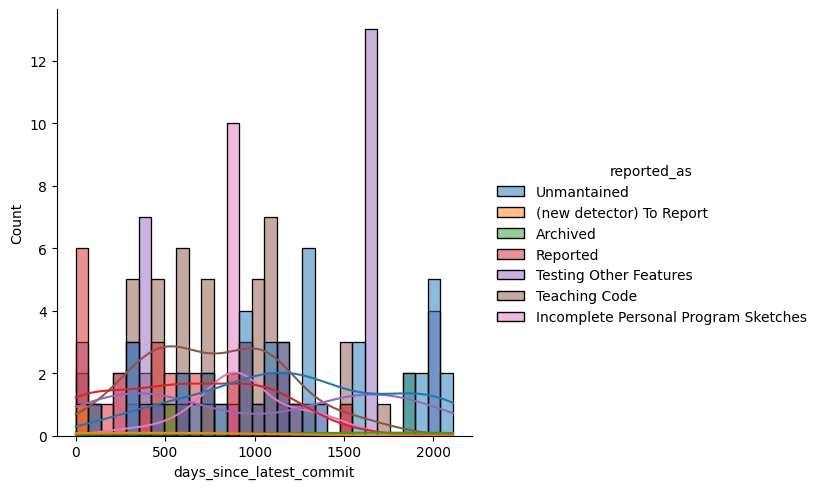

In [36]:
sns.displot(
    data=df_to_explore,
    x="days_since_latest_commit",
    # y="issues",
    bins=30,
    kde=True,
    hue="reported_as")

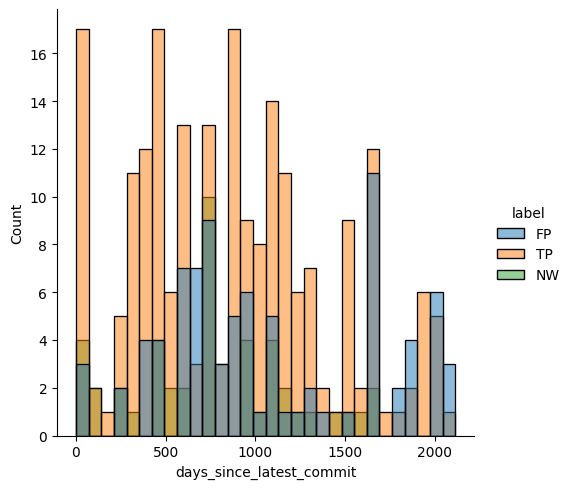

In [19]:
sns.displot(
    df_with_url,
    x="days_since_latest_commit",
    hue="label",
    bins=30)

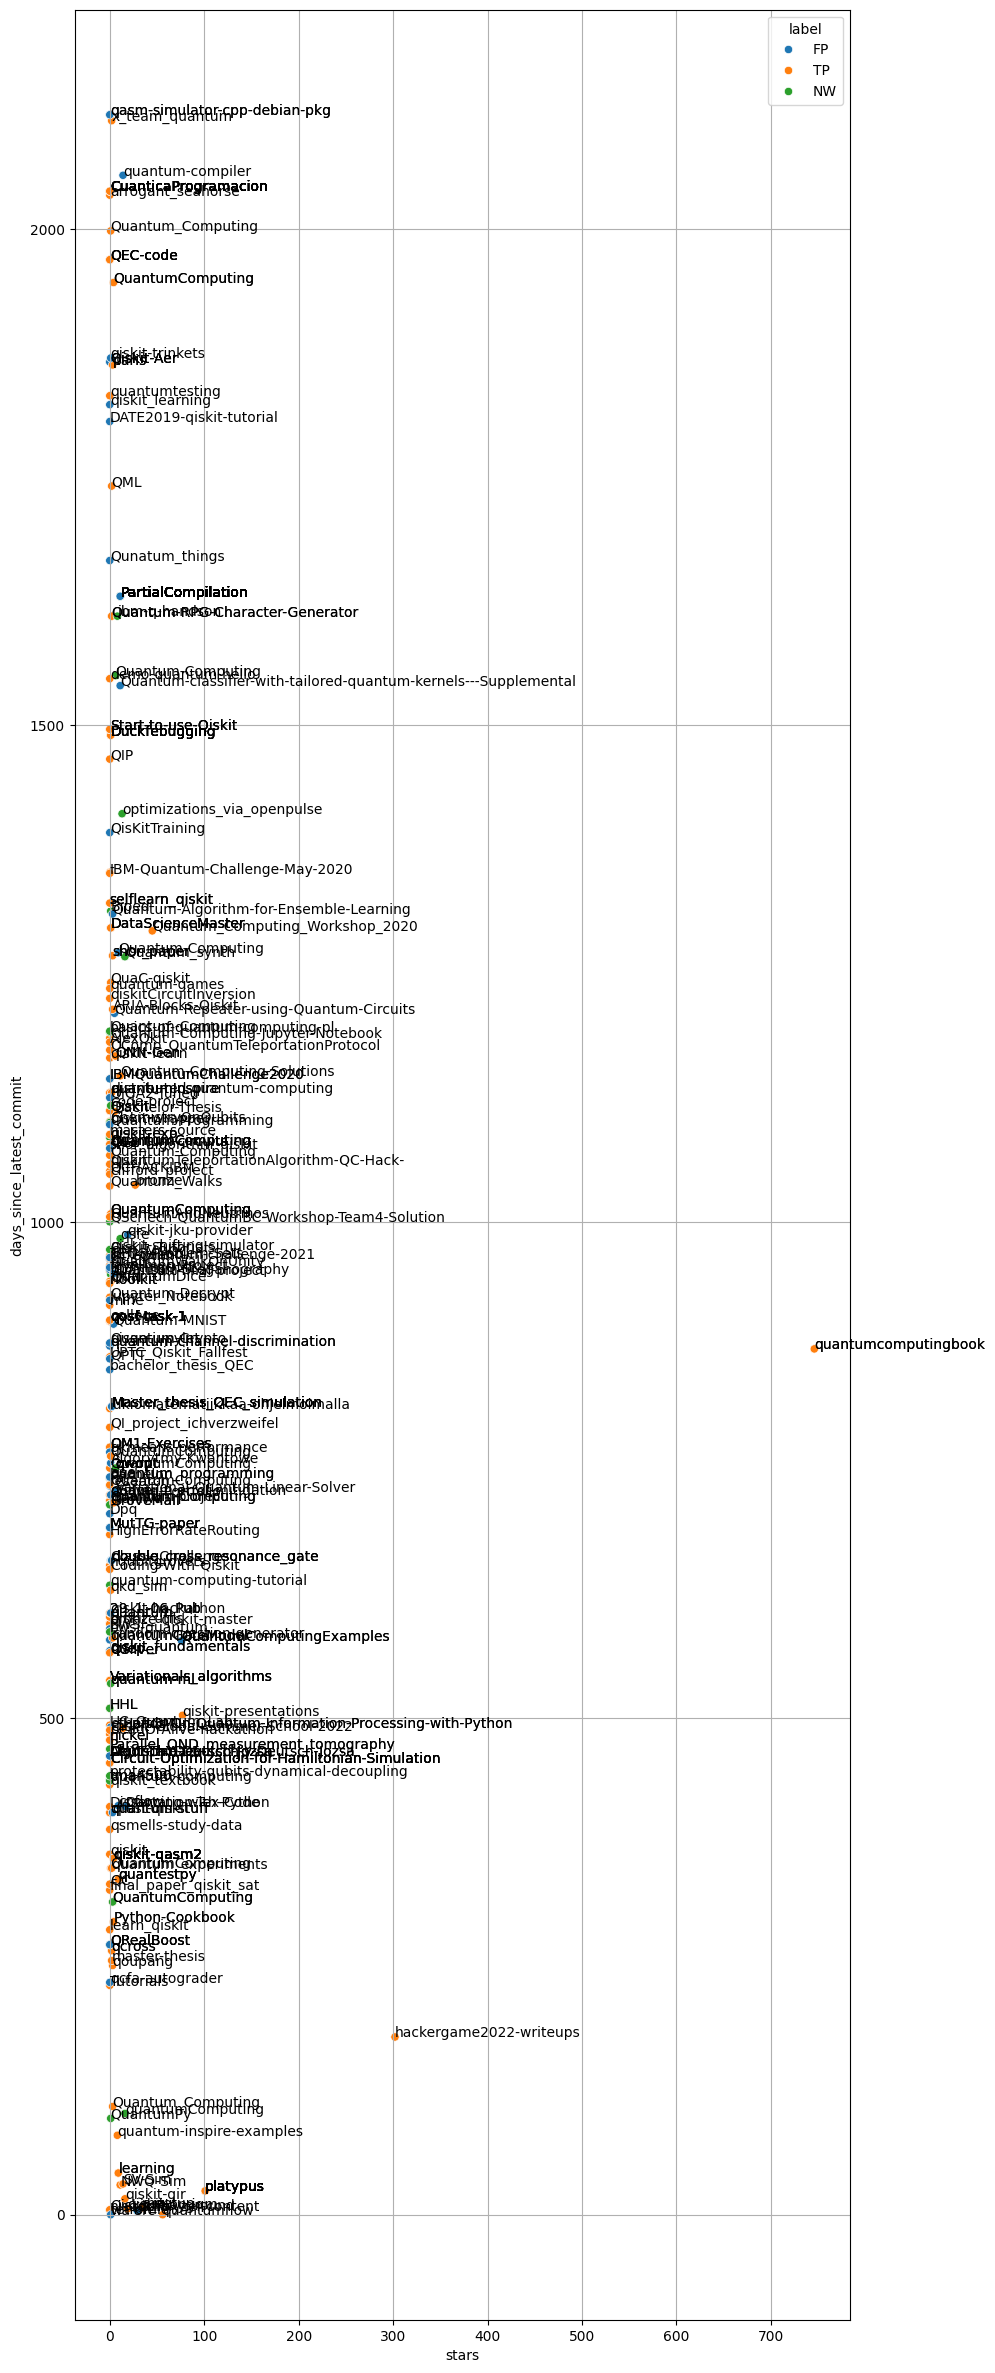

In [20]:
plt.figure(figsize=(10, 30))  # Set the figure size

sns.scatterplot(
    data=df_with_url,
    y="days_since_latest_commit",
    x="stars",
    hue="label",
)

# Add labels next to the dots
for i in range(len(df_with_url)):
    plt.text(
        df_with_url["stars"][i],
        df_with_url["days_since_latest_commit"][i],
        df_with_url["name"][i])

plt.grid(True)  # Add grid lines

plt.show()  # Show the plot


In [21]:
TOP_K = 75

df_to_prioritize = df_with_url.copy()

columns_to_rank = ['stars', 'issues', 'contributors', 'days_since_latest_commit']

for column in columns_to_rank:
    if column == 'days_since_latest_commit':
        df_to_prioritize[f'{column}_percentile'] = df_to_prioritize[column].rank(
            pct=True, ascending=False)
    else:
        df_to_prioritize[f'{column}_percentile'] = df_to_prioritize[column].rank(
            pct=True)

# scoring
df_to_prioritize['score'] = df_to_prioritize['stars_percentile'] + \
    df_to_prioritize['issues_percentile'] + \
    df_to_prioritize['contributors_percentile'] + \
    df_to_prioritize['days_since_latest_commit_percentile']

# sort by score
df_to_prioritize = df_to_prioritize.sort_values(by='score', ascending=False)

# keep rule_id, message, file, line, col, label, score
df_to_prioritize = df_to_prioritize[
    ['rule_id', 'message', 'file', 'line', 'col', 'label', 'score'] + columns_to_rank]

# keep only label == 'TP'
df_to_prioritize = df_to_prioritize[df_to_prioritize['label'] == 'TP']

# create the code from file and line:
# e.g. test_mc_gate_13ba80.py	107 becomes, 13ba80_107
df_to_prioritize.insert(0, 'code', df_to_prioritize.apply(
    lambda row: f"{row['file'].split('_')[-1].split('.')[0]}_{row['line']}", axis=1))

df_to_prioritize.head(TOP_K)


code                             rule_id  \
110   12fb50_70                ql-measure-all-abuse   
185   768589_16             ql-constant-classic-bit   
294  9dfa5b_238                ql-oversized-circuit   
257  bd6143_366                ql-oversized-circuit   
54   13ba80_124                ql-ghost-composition   
..          ...                                 ...   
57    78732d_60  ql-conditional-without-measurement   
63    78732d_59  ql-conditional-without-measurement   
172   c4c34f_45            ql-op-after-optimization   
173   c4c34f_59            ql-op-after-optimization   
174   c4c34f_64            ql-op-after-optimization   

                                               message  \
110  measure_all() on the circuit 'qc' (at location...   
185  Circuit 'circuit' measures qubit '0' but never...   
294  Circuit 'circuit_2' never manipulates some of ...   
257  Circuit 'circuit' never manipulates some of it...   
54             Ghost composition at location: (124, 9)   
..                                                 ...   
57   Conditional gate 'h' on qubit '2' (l: 60, c: 5...   
63   Conditional gate 'h' on qubit '1' (l: 59, c: 5...   
172  Operation measure_all applied to transpiled ci...   
173  Operation measure_all applied to transpiled ci...   
174  Operation measure_all applied to transpiled ci...   

                                     file  line   col label     score  stars  \
110                        code_12fb50.py    70   NaN    TP  3.824286  302.0   
185                 tabula_rasa_768589.py    16  11.0    TP  3.761429   34.0   
294            test_iqm_backend_9dfa5b.py   238  17.0    TP  3.754286   19.0   
257                 test_output_bd6143.py   366  15.0    TP  3.705714   16.0   
54                 test_mc_gate_13ba80.py   124   9.0    TP  3.690000   29.0   
..                                    ...   ...   ...   ...       ...    ...   
57   example_qiskit_conditional_78732d.py    60   5.0    TP  2.181429    0.0   
63   example_qiskit_conditional_78732d.py    59   5.0    TP  2.181429    0.0   
172                 real_system_c4c34f.py    45   5.0    TP  2.175714    0.0   
173                 real_system_c4c34f.py    59   5.0    TP  2.175714    0.0   
174                 real_system_c4c34f.py    64   5.0    TP  2.175714    0.0   

     issues  contributors  days_since_latest_commit  
110     5.0          30.0                     179.0  
185     2.0           9.0                       7.0  
294     2.0          13.0                       6.0  
257     2.0           7.0                      16.0  
54      1.0           9.0                       4.0  
..      ...           ...                       ...  
57      1.0           3.0                    1130.0  
63      1.0           3.0                    1130.0  
172     1.0           1.0                     455.0  
173     1.0           1.0                     455.0  
174     1.0           1.0                     455.0  

[75 rows x 12 columns]

In [82]:

TOP_K = 15
COLUMN_TO_SHOW = ["name", "file", "line", "col", "stars", "issues", "contributors", "days_since_latest_commit"]


ATTRIBUTES_TO_PRIORITIZE = [
    "stars",
    "issues",
    "contributors",
    "days_since_latest_commit",
]

# keep only TP
df_to_prioritize = df_with_url[df_with_url["label"] == "TP"]
df


for attr in ATTRIBUTES_TO_PRIORITIZE:
    order_ascending = False
    if attr == "days_since_latest_commit":
        order_ascending = True
    df_to_prioritize = df_to_prioritize.sort_values(
        by=[attr], ascending=order_ascending)
    print(f"Top {TOP_K} {attr}:")
    display(df_to_prioritize[COLUMN_TO_SHOW].head(TOP_K))

Top 15 stars:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
63,Quantum_Computing_Workshop_2020,day_203_20universality_69a67f.py,271,7.0,45.0,1.0,4.0,1258.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
41,Hands-On-Quantum-Information-Processing-with-P...,ch_3_28325b.py,157,NaN,14.0,0.0,3.0,456.0
21,PartialCompilation,test_qasm_simulator_edd048.py,61,9.0,11.0,0.0,3.0,1596.0
18,PartialCompilation,test_circuit_qasm_ae5268.py,47,9.0,11.0,0.0,3.0,1596.0
12,PartialCompilation,test_decompose_78559e.py,75,9.0,11.0,0.0,3.0,1596.0
17,PartialCompilation,test_circuit_load_from_qasm_bf30ab.py,114,9.0,11.0,0.0,3.0,1596.0
11,PartialCompilation,test_decompose_78559e.py,83,9.0,11.0,0.0,3.0,1596.0


Top 15 issues:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
24,tetromiq,quantum_e3f4e0.py,74,5.0,1.0,15.0,3.0,848.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
35,Duckfebugging,one_qubit_fb6117.py,40,NaN,1.0,6.0,2.0,1456.0
60,29_1_06_Pub,4atoms_of_computation_332679.py,126,6.0,0.0,6.0,2.0,572.0
32,random-question-generator,qrng_9498d5.py,10,5.0,3.0,3.0,4.0,547.0
44,Dissertation-Tex-Code,groverfuncs_9232ea.py,55,5.0,0.0,2.0,2.0,377.0
47,Circuit-Optimization-for-Hamiltonian-Simulation,real_system_c4c34f.py,59,5.0,0.0,1.0,1.0,421.0


Top 15 contributors:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
16,quantum-project,test_sdk_352e8e.py,34,NaN,1.0,0.0,5.0,685.0
63,Quantum_Computing_Workshop_2020,day_203_20universality_69a67f.py,271,7.0,45.0,1.0,4.0,1258.0
32,random-question-generator,qrng_9498d5.py,10,5.0,3.0,3.0,4.0,547.0
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
24,tetromiq,quantum_e3f4e0.py,74,5.0,1.0,15.0,3.0,848.0
12,PartialCompilation,test_decompose_78559e.py,75,9.0,11.0,0.0,3.0,1596.0
41,Hands-On-Quantum-Information-Processing-with-P...,ch_3_28325b.py,157,NaN,14.0,0.0,3.0,456.0


Top 15 days_since_latest_commit:


,name,file,line,col,stars,issues,contributors,days_since_latest_commit
8,qclib,test_mc_gate_13ba80.py,90,9.0,26.0,9.0,9.0,80.0
0,qclib,test_mc_gate_13ba80.py,124,9.0,26.0,9.0,9.0,80.0
7,qclib,test_mc_gate_13ba80.py,107,9.0,26.0,9.0,9.0,80.0
50,qcross,source_948f90de9947418289b220bd2e61caa3_caae3b.py,58,NaN,2.0,0.0,1.0,232.0
49,qcross,source_59a0eb956a0d4e6b8720f272136f2799_9b8ba7.py,34,NaN,2.0,0.0,1.0,232.0
66,quantestpy,test_u_gate_940648.py,43,14.0,9.0,29.0,3.0,304.0
40,QuantumComputing,quantum_key_distribution_e8abe3.py,73,NaN,0.0,0.0,1.0,315.0
13,qiskit-qasm2,test_structure_aaba85.py,245,9.0,4.0,0.0,1.0,325.0
44,Dissertation-Tex-Code,groverfuncs_9232ea.py,55,5.0,0.0,2.0,2.0,377.0
48,Circuit-Optimization-for-Hamiltonian-Simulation,real_system_c4c34f.py,64,5.0,0.0,1.0,1.0,421.0


In [ ]:
df_warnings_annotated = pd.read_csv(PATH_LINTQ_ANNOTATION)
n_tot = len(df_warnings_annotated)
# consider only the TP
df_TP_warnings_annotated = df_warnings_annotated[
    df_warnings_annotated["Last Round"] == "TP"
]
n_tp = len(df_TP_warnings_annotated)
print(f"TP: {n_tp} / {n_tot} ({n_tp/n_tot:.2%})")

mapping_reported_as = {
    "no_inactive": "No inactive",
    "no_single_file_repo": "No single file repo",
    "no_because_test": "No because test",
    "no_teaching_code": "No teaching code",
    "commented_in_related_report": "Reported",
    "new_report": "Reported",
    "no_sketch_code": "No sketch code",
    "TO_REPORT": "(new detector) To Report"
}
# map reported_as column to a more readable format
# use the map function
df_TP_warnings_annotated["reported_as"] = \
    df_TP_warnings_annotated["reported_as"].map(
        mapping_reported_as)

# plot a count plot on the "reported_as" column
fig, ax = plt.subplots(figsize=(5, 2.5))
sns.countplot(
    data=df_TP_warnings_annotated,
    y="reported_as",
    palette="viridis",
    ax=ax
)